
    Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
    
    Сделать обзорный анализ выбранного датасета
    
    Обучить любой классификатор (какой вам нравится)
    
    разобраться с SHAP и построить важности признаков для:
        всего тестового набора данных (summary_plot - дать интерпретацию)
        для 5 случайных объектов из тестового набора



In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### 1. Какое соотношение выживших и нет в представленном наборе данных?

In [3]:
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [4]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
features = ['Pclass','Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked']
target = 'Survived'
all_features = ['Age', 'SibSp', 'Parch',
       'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3','Sex_female', 'Sex_male','Embarked_C', 'Embarked_Q', 'Embarked_S']

# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)

In [7]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
105,3,male,28.0,0,0,7.8958,S
68,3,female,17.0,4,2,7.9250,S
253,3,male,30.0,1,0,16.1000,S
320,3,male,22.0,0,0,7.2500,S
706,2,female,45.0,0,0,13.5000,S
...,...,...,...,...,...,...,...
835,1,female,39.0,1,1,83.1583,C
192,3,female,19.0,1,0,7.8542,S
629,3,male,NaN,0,0,7.7333,Q
559,3,female,36.0,1,0,17.4000,S


Соберем пайплайн

In [8]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        self.medians = X.median()
        self.modes=X.mode()
        return self

    def transform(self, X):
         #'Age'
       
        
        X['Age'] = X['Age'].fillna(self.medians['Age'])
        
        # 'Fare'
        X['Fare'] = X['Fare'].fillna(self.medians['Fare'])
        
        # Embarked
        
        X['Embarked'] = X['Embarked'].fillna(self.modes['Embarked'][0])
        
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [9]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
105,3,male,28.0,0,0,7.8958,S
68,3,female,17.0,4,2,7.9250,S
253,3,male,30.0,1,0,16.1000,S
320,3,male,22.0,0,0,7.2500,S
706,2,female,45.0,0,0,13.5000,S


Зададим списки признаков

In [10]:
categorical_columns = ['Pclass', 'Sex', 'Embarked' ]
continuous_columns = ['Age', 'SibSp', 'Parch', 'Fare']

In [11]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    
    final_transformers.append((cont_col, cont_transformer))

In [12]:
final_transformers

[('Pclass',
  Pipeline(steps=[('selector', FeatureSelector(column='Pclass')),
                  ('ohe', OHEEncoder(key='Pclass'))])),
 ('Sex',
  Pipeline(steps=[('selector', FeatureSelector(column='Sex')),
                  ('ohe', OHEEncoder(key='Sex'))])),
 ('Embarked',
  Pipeline(steps=[('selector', FeatureSelector(column='Embarked')),
                  ('ohe', OHEEncoder(key='Embarked'))])),
 ('Age', Pipeline(steps=[('selector', NumberSelector(key='Age'))])),
 ('SibSp', Pipeline(steps=[('selector', NumberSelector(key='SibSp'))])),
 ('Parch', Pipeline(steps=[('selector', NumberSelector(key='Parch'))])),
 ('Fare', Pipeline(steps=[('selector', NumberSelector(key='Fare'))]))]

In [13]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
495,3,male,NaN,0,0,14.4583,C
648,3,male,NaN,0,0,7.5500,S
278,3,male,7.0,4,1,29.1250,Q
31,1,female,NaN,1,0,146.5208,C
255,3,female,29.0,0,2,15.2458,C


In [14]:
feats = FeatureUnion(final_transformers)

In [15]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

In [16]:
# обучим наш пайплайн
pipeline.fit(X_train, y_train)

/tmp/ipykernel_18800/842247870.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.medians = X.median()


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Pclass',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Pclass')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Pclass'))])),
                                                ('Sex',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Sex')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Sex'))])),
                                                ('Embarked',
                                                 Pipeline(steps=[('selector',
                           

In [17]:
# наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.34666667, 0.24666667, 0.01      , 0.89      , 0.76      ,
       0.38452381, 0.97      , 0.75      , 0.67      , 0.72142857])

In [18]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.44, F-Score=0.762, Precision=0.762, Recall=0.762


In [20]:
predictions = pipeline.predict(X_test)
predictions

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1])

In [21]:
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
495,3,male,29.0,0,0,14.4583,C
648,3,male,29.0,0,0,7.5500,S
278,3,male,7.0,4,1,29.1250,Q
31,1,female,29.0,1,0,146.5208,C
255,3,female,29.0,0,2,15.2458,C
...,...,...,...,...,...,...,...
167,3,female,45.0,1,4,27.9000,S
306,1,female,29.0,0,0,110.8833,C
379,3,male,19.0,0,0,7.7750,S
742,1,female,21.0,2,2,262.3750,C


In [22]:
rfc_features = pd.DataFrame(pipeline[1].feature_importances_, 
                            all_features, 
                            columns=['coefficient'])

rfc_features.sort_values('coefficient', ascending=False)

,coefficient
Sex_male,0.251667
Embarked_S,0.235018
Pclass_1,0.152959
Fare,0.135818
Embarked_C,0.053460
Parch,0.050442
Embarked_Q,0.037839
Age,0.026096
Sex_female,0.016929
SibSp,0.015555


Как это можно интерпретировать:

1. Sex_male гендорный признак имеет наибольшую важность(возможно потому что в первую очередь на спасительные шлюпки сажали женщин)
2. Embarked_S и Pclass_(возможно тк впервую очередь спасали первый класс) 
3. Fare (цена билета влияет на статус и класс)

## 2. Permutation importance

In [23]:
from sklearn.inspection import permutation_importance

r = permutation_importance(pipeline, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [24]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{all_features[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

SibSp    0.164 +/- 0.022
Age      0.072 +/- 0.021
Parch    0.054 +/- 0.016
Pclass_2 0.027 +/- 0.013
Pclass_3 0.022 +/- 0.010
Pclass_1 0.005 +/- 0.008
Fare     -0.002 +/- 0.006


При перемешивании SibSp худшие показатели

Результаты Fare и Pclass похожи как при использовании "встроенного" feature_importances


## SHAP

In [25]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [26]:
# # строим модель объяснения в SHAP
# # (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
# explainer = shap.TreeExplainer(pipeline)
# shap_values = explainer.shap_values(X_test)

# # покажем объяснение
# shap.initjs() # для работы в колабе
# shap.summary_plot(shap_values, X_test)

In [27]:
# Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>
# Не сообразил как исправить

In [28]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [29]:
class FeatureImputer:
    """Заполнение пропусков"""
    
    def __init__(self):
        self.medians=None
        self.modes=None
        
    def fit(self, X):
        self.medians = X.median()
        self.modes=X.mode()
    
    def transform(self, X):
        
        # ставим индексом PassengerId
#         X.set_index('PassengerId',inplace=True)
        
        
        #Заполнение пропусков
        
        # 'Age'
        X['Age_outlier'] = 0
        X.loc[X['Age'].isna(), 'Age_outlier'] = 1
        
        X['Age'] = X['Age'].fillna(self.medians['Age'])
        
        # 'Fare'
        X['Fare'] = X['Fare'].fillna(self.medians['Fare'])
        
        # Embarked
        X['Embarked_outlier'] = 0
        X.loc[X['Embarked'].isna(), 'Embarked_outlier'] = 1
        
        X['Embarked'] = X['Embarked'].fillna(self.modes['Embarked'][0])
        
        
        # Выбросы
        
        # Parch
        X['Parch_outlier'] = 0
        X.loc[X['Parch']>2, 'Parch_outlier'] = 1
        
        X.loc[X['Parch'] > 2, 'Parch'] = 0
        
        # SibSp
        X['SibSp_outlier'] = 0
        X.loc[X['SibSp']>2, 'SibSp_outlier'] = 1
        
        X.loc[X['SibSp'] > 2, 'SibSp'] = 3
        
        
        # Приведение типов
#         cat_colomns=['Pclass','Sex','SibSp','Parch','Embarked']
#         for colname in cat_colomns:
#             X[colname] = X[colname].astype('category')
        
        #Удалим
        
        # Cabin
        if 'Cabin' in X.columns:
            X.drop('Cabin', axis=1, inplace=True)
        # Name
        if 'Name' in X.columns:
            X.drop('Name', axis=1, inplace=True)
        # Ticket
        if 'Ticket' in X.columns:
            X.drop('Ticket', axis=1, inplace=True)
        if 'PassengerId' in X.columns:
            X.drop('PassengerId', axis=1, inplace=True)
            
            
        
        #Dummies
        
        #SEX - Пол (1=мужчина, 2=женщина)
        X['Sex'] = X['Sex'].map({'male':1, 'female':0}).astype(int)
#         X['IS_MALE'] = X['Sex'].map({'1':'1', '0':'0'}).astype(int)
        
        # C = 1, Q = 2, S = 3
        X['Embarked'] = X['Embarked'].map({'C':'1', 'Q':'2', 'S':'3'}).astype(int)
        
        
        
#         for cat_colname in X.select_dtypes(include='category'):
#             X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)
        
        
        return X

In [30]:
imputer = FeatureImputer()

imputer.fit(df) # расчет медиан

df = imputer.transform(df)

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [31]:
features = ['Age', 'SibSp', 'Parch',
       'Fare', 'Sex','Embarked','Pclass']


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Survived          891 non-null    int64  
 1   Pclass            891 non-null    int64  
 2   Sex               891 non-null    int64  
 3   Age               891 non-null    float64
 4   SibSp             891 non-null    int64  
 5   Parch             891 non-null    int64  
 6   Fare              891 non-null    float64
 7   Embarked          891 non-null    int64  
 8   Age_outlier       891 non-null    int64  
 9   Embarked_outlier  891 non-null    int64  
 10  Parch_outlier     891 non-null    int64  
 11  SibSp_outlier     891 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 83.7 KB


In [33]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)

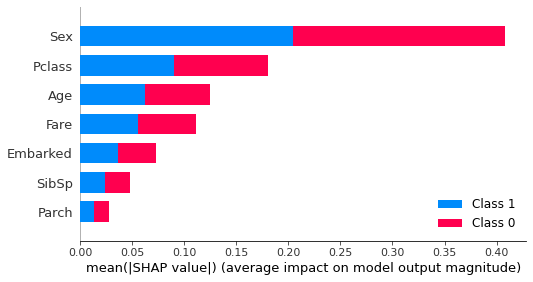

In [34]:
rfc_model = RandomForestClassifier(random_state=42)
rfc_model.fit(X_train, y_train)

y_preds = rfc_model.predict(X_test)

# строим модель объяснения в SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(rfc_model)
shap_values = explainer.shap_values(X_test)

# покажем объяснение
shap.initjs() # для работы в колабе
shap.summary_plot(shap_values, X_test)

Будем анализировать только первый класс - целевой.

Explained expected value: [[-0.02536552  0.01997687 -0.02329526 ... -0.12843847  0.10800061
  -0.06749449]
 [ 0.01316385  0.00958344 -0.00428814 ... -0.11531599  0.00173278
  -0.04257974]
 [ 0.12110433 -0.16175504  0.00854202 ... -0.10530052 -0.02081111
  -0.1432217 ]
 ...
 [-0.06746686  0.00217591 -0.0098502  ... -0.13846665 -0.03971697
  -0.08341791]
 [ 0.01751165 -0.02894749 -0.02434617 ...  0.24761709  0.0716801
   0.12830725]
 [ 0.20779612  0.02880899  0.04033338 ...  0.14640986 -0.02629352
  -0.12488369]]


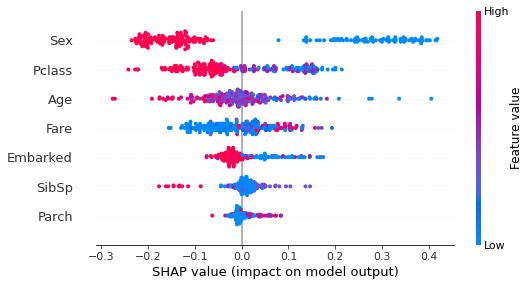

In [35]:
if isinstance(shap_values, list):
    shap_values = shap_values[1]

print(f'Explained expected value: {shap_values}')

shap.summary_plot(shap_values, X_test)

Проанализируем вещественные:
    - Sex - мужчины стремяться к 0 таргету, а женщины к 1 (четко разделены)
    
    - Pclass: 3 класс - стремиться к 0 таргету, когда 1 к 1 таргету

    - Чем цена за билет (Fare) ниже, тем явней 0 класс(погибшие) и наоборот
    
    - Age очень возрастные люди явней 0 класс(погибшие)
    
    - Fare, чем выше стоимость билета тем больше шансов выжить
    
    - Embarked по портам тоже довольно четкое распределение. 
    

### Тоже решил посмотреть xgboost

In [36]:
import xgboost

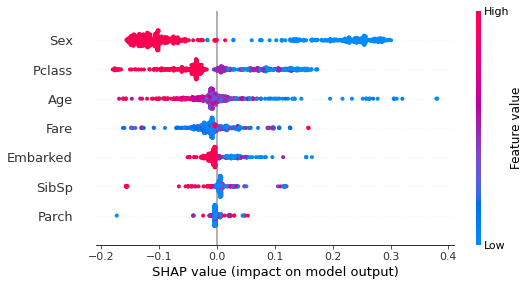

In [37]:
model = xgboost.train({"learning_rate": 0.01, 'random_state': 1}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values_all = explainer.shap_values(X_train)

shap.summary_plot(shap_values_all, X_train)

### Интепритация по одному обьекту

In [38]:
# visualize the first prediction's explanation
shap.initjs()
idx = 2
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_train.iloc[idx,:])

- базовое значение 0.429, а предсказание 0.22
- мужчина, 3 класс, возраст все склоняет его к 0 таргету


In [41]:
shap.initjs()
idx = 10
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_train.iloc[idx,:])

- несмотря на 3 класс каюты, возрост и пол (женский) дают шансы спастись

In [43]:
shap.initjs()
idx = 25
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_train.iloc[idx,:])

- Только SibSp = 0, дает шансы выжить, но они очень незначительные из за пола, возраста, Embarked

Отрисуем его по другому (графику)

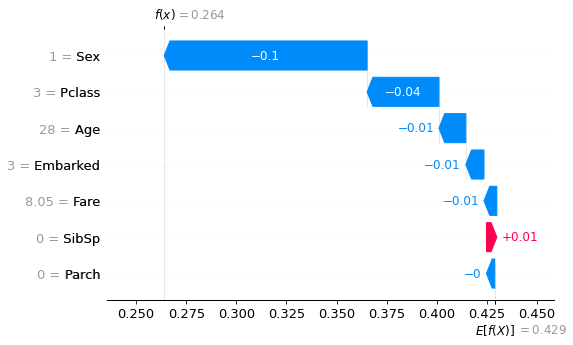

In [44]:
shap_values_one = explainer(X_train.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])